In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch

# Gated Recurrent Units: Implementation

* In this lab session, you will implement a autoregressive language model based on a gated recurrent unit network in PyTorch.

* This model will be trained using the book [Frankenstein; or, The Modern Prometheus](https://www.gutenberg.org/cache/epub/84/pg84.txt) by Mary Wollstonecraft Shelley.



# Organizing the Dataset


* The following code downloads the book and stores it into a Python string.

In [2]:
import requests

# Project Gutenberg has many books stored as text files (https://www.gutenberg.org/)
raw_text = requests.get('https://www.gutenberg.org/cache/epub/84/pg84.txt').text # Downloads and stores the text into a string
raw_text = raw_text.partition('*** START OF THE PROJECT GUTENBERG EBOOK FRANKENSTEIN; OR, THE MODERN PROMETHEUS ***')[2] # Removes foreword
raw_text = raw_text.partition('*** END OF THE PROJECT GUTENBERG EBOOK FRANKENSTEIN; OR, THE MODERN PROMETHEUS ***')[0] # Removes afterword

* In the following code:
    * The function `preprocess` converts a string so that any sequence of non-letters is substituted by a whitespace and uppercase letters are substituted by corresponding lowercase letters.
    * The function `tokenize` converts a string into a list of tokens (in this case, characters).
    * The class `Vocabulary` implements a vocabulary.

In [3]:
import re
import collections


def preprocess(text):
    text = re.sub('[^A-Za-z]+', ' ', text) # Substitutes any sequence of non-letters by a whitespace
    text = text.lower() # Converts uppercase letters to lowercase letters

    return text


def tokenize(text, use_chars):
    if use_chars: # One token for each character
        return list(text)
    else: # One token for each sequence of letters
        return text.split()


class Vocabulary:
    def __init__(self, tokens):
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True) # List of pairs where each pair is composed of a token and its frequency. Sorted according to decreasing frequency.

        self.unknown = '?' # Represents an unknown token

        self.id_to_token = sorted([token for token, freq in self.token_freqs]) + [self.unknown] # Maps an index to a token
        self.token_to_id = {token: id for id, token in enumerate(self.id_to_token)} # Maps a token to an index

    def __len__(self):
        return len(self.id_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)): # If called with a single token
            return self.token_to_id.get(tokens, self.token_to_id[self.unknown])
        else: # If called with a list of tokens
            return [self.token_to_id.get(token, self.token_to_id[self.unknown]) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)): # If called with a single index
            return self.id_to_token[indices]
        else: # If called with a list of indices
            return [self.id_to_token[index] for index in indices]

* The following code converts the raw text into a sequence of numbers, each of which corresponds to a token (in this case, a character).

In [4]:
text = preprocess(raw_text)
print(text[:38]) # Prints the first 38 characters

tokens = tokenize(text, use_chars=True)
print(tokens[:38])

vocab = Vocabulary(tokens)
print(vocab.id_to_token)

indices = vocab[tokens]
print(indices[:38])

tokens_from_indices = vocab.to_tokens(indices)
print(tokens_from_indices[:38])

 frankenstein or the modern prometheus
[' ', 'f', 'r', 'a', 'n', 'k', 'e', 'n', 's', 't', 'e', 'i', 'n', ' ', 'o', 'r', ' ', 't', 'h', 'e', ' ', 'm', 'o', 'd', 'e', 'r', 'n', ' ', 'p', 'r', 'o', 'm', 'e', 't', 'h', 'e', 'u', 's']
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '?']
[0, 6, 18, 1, 14, 11, 5, 14, 19, 20, 5, 9, 14, 0, 15, 18, 0, 20, 8, 5, 0, 13, 15, 4, 5, 18, 14, 0, 16, 18, 15, 13, 5, 20, 8, 5, 21, 19]
[' ', 'f', 'r', 'a', 'n', 'k', 'e', 'n', 's', 't', 'e', 'i', 'n', ' ', 'o', 'r', ' ', 't', 'h', 'e', ' ', 'm', 'o', 'd', 'e', 'r', 'n', ' ', 'p', 'r', 'o', 'm', 'e', 't', 'h', 'e', 'u', 's']


* For a pre-defined batch size $n$ and a pre-defined number of steps $T$, the sequence of indices will be partitioned into subsequences of length $T$, which will be grouped into batches of size $n$.

* The following code implements sequential partitioning using a Python generator.


In [5]:
def sequential_partitioning(sequence, batch_size, num_steps, offset=None, batch_first=False):
    if offset is None:
        offset = int(torch.randint(num_steps, (1,))) # A random number between 0 and `num_steps` (excluding `num_steps`)

    sequence = sequence[offset:] # Discards the first `offset` elements of the sequence

    len_macro_subseq = (len(sequence) - 1) // batch_size # The length of each macro-subsequence. There is one macro-subsequence for each unit of batch size

    num_elements = len_macro_subseq * batch_size # The number of elements that fit into the macro-subsequences

    Xs = torch.tensor(sequence[: num_elements]) # Selects the elements that fit into the macro-subsequences
    Ys = torch.tensor(sequence[1: num_elements + 1]) # Selects the elements that fit into the macro-subsequences (shifted by one index)

    Xs = Xs.reshape(batch_size, -1) # Each row of this matrix corresponds to a macro-subsequence
    Ys = Ys.reshape(batch_size, -1) # Each row of this matrix corresponds to a macro-subsequence (shifted by one index)

    num_subseqs = Xs.shape[1] // num_steps # The number of subsequences that fit into each macro-subsequence

    for i in range(0, num_subseqs * num_steps, num_steps):
        X = Xs[:, i: i + num_steps] # Each row of `X` contains a subsequence from a distinct macro-subsequence
        Y = Ys[:, i: i + num_steps] # Each row of `Y` contains a subsequence from a distinct macro-subsequence (shifted by one index)

        if batch_first:
            yield X, Y # Yields a pair of `batch_size` x `num_steps` matrices
        else:
            yield X.T, Y.T # Yields a pair of `num_steps` x `batch_size` matrices

* The following code displays the first three batches of input subsequences and target subsequences (converted into batches of tokens).

In [6]:
import numpy as np

print('Partitioning and batching the sequence of token indices (first three batches, converted into batches of tokens):')
for i, (X, Y) in enumerate(sequential_partitioning(indices, batch_size=4, num_steps=16, offset=0)):
    X_tokens = np.array([vocab.to_tokens(list(X[j])) for j in range(X.shape[0])])
    Y_tokens = np.array([vocab.to_tokens(list(Y[j])) for j in range(Y.shape[0])])
    print(f'Inputs: \n{X_tokens}.')
    print(f'Targets: \n{Y_tokens}.\n')
    print()

    if i >= 2:
        break

Partitioning and batching the sequence of token indices (first three batches, converted into batches of tokens):
Inputs: 
[[' ' 'i' ' ' ' ']
 ['f' 's' 'a' 'o']
 ['r' ' ' 't' 'n']
 ['a' 'm' ' ' 'l']
 ['n' 'a' 'p' 'y']
 ['k' 'n' 'r' ' ']
 ['e' 'y' 'e' 't']
 ['n' ' ' 's' 'h']
 ['s' 'l' 'e' 'e']
 ['t' 'e' 'n' ' ']
 ['e' 't' 't' 's']
 ['i' 't' ' ' 'o']
 ['n' 'e' 'e' 'u']
 [' ' 'r' 'x' 'n']
 ['o' 's' 'i' 'd']
 ['r' ' ' 's' ' ']].
Targets: 
[['f' 's' 'a' 'o']
 ['r' ' ' 't' 'n']
 ['a' 'm' ' ' 'l']
 ['n' 'a' 'p' 'y']
 ['k' 'n' 'r' ' ']
 ['e' 'y' 'e' 't']
 ['n' ' ' 's' 'h']
 ['s' 'l' 'e' 'e']
 ['t' 'e' 'n' ' ']
 ['e' 't' 't' 's']
 ['i' 't' ' ' 'o']
 ['n' 'e' 'e' 'u']
 [' ' 'r' 'x' 'n']
 ['o' 's' 'i' 'd']
 ['r' ' ' 's' ' ']
 [' ' 'w' 't' 'o']].


Inputs: 
[[' ' 'w' 't' 'o']
 ['t' 'e' 'i' 'f']
 ['h' ' ' 'n' ' ']
 ['e' 'a' 'g' 't']
 [' ' 'r' ' ' 'h']
 ['m' 'e' 'i' 'e']
 ['o' ' ' 'n' ' ']
 ['d' 's' ' ' 'b']
 ['e' 'i' 't' 'o']
 ['r' 'n' 'h' 'a']
 ['n' 'c' 'e' 't']
 [' ' 'e' ' ' ' ']
 ['p' 'r' 'w' 'a'

# Task 1: Gated Recurrent Unit Layer

* **Your task is to implement a gated recurrent unit as a PyTorch module called `GRU`**. PyTorch implements an analogous module called [`torch.nn.GRU`](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html).

* The method `forward` should receive a $T \times n \times d$ tensor called `input`, where $T$ is the number of time steps, $n$ is the batch size, and $d$ is the size of the vocabulary (number of distinct tokens). It should also receive a $1 \times n \times h$ tensor called `h_0`, where $h$ is the number of units in the gated recurrent unit layer.
    * If the tensor `input` is interpreted as a list of $T$ matrices, each of these matrices corresponds to a single time step. Each matrix has one row for each unit of batch size, so that each row contains a (transposed) input vector. These input vectors are the result of one-hot encoding a token into a vector with $d$ elements.
    * If the tensor `h_0` is interpreted as a list with a single matrix, this matrix corresponds to the initial hidden state matrix.

* The method `forward` should output a $T \times n \times h$ tensor called `outputs`. It should also output a $1 \times n \times h$ tensor called `state`.
    * If the tensor `outputs` is interpreted as a list of $T$ matrices, each of these matrices corresponds to a single time step. Each matrix has one row for each unit of batch size, so that each row contains a (transposed) hidden state vector.

    * If the tensor `state` is interpreted as a list with a single matrix, this matrix corresponds to the last hiddden state matrix.

In [7]:
class GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, sigma=0.01):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        # Reset gate parameters
        self.WIR = torch.nn.Parameter(torch.randn(input_size, hidden_size) * sigma) # An `input_size` x `hidden_size` weight matrix that transforms the current input vectors
        self.WRR = torch.nn.Parameter(torch.randn(hidden_size, hidden_size) * sigma) # A `hidden_size` x `hidden_size` weight matrix that transforms the previous hidden state vectors
        self.bR = torch.nn.Parameter(torch.zeros(hidden_size)) # A bias vector with `hidden_size` elements

        # Update gate parameters
        self.WIZ = torch.nn.Parameter(torch.randn(input_size, hidden_size) * sigma) # An `input_size` x `hidden_size` weight matrix that transforms the current input vectors
        self.WRZ = torch.nn.Parameter(torch.randn(hidden_size, hidden_size) * sigma) # A `hidden_size` x `hidden_size` weight matrix that transforms the previous hidden state vectors
        self.bZ = torch.nn.Parameter(torch.zeros(hidden_size)) # A bias vector with `hidden_size` elements

        # Candidate hidden state parameters
        self.WIH = torch.nn.Parameter(torch.randn(input_size, hidden_size) * sigma) # An `input_size` x `hidden_size` weight matrix that transforms the current input vectors
        self.WRH = torch.nn.Parameter(torch.randn(hidden_size, hidden_size) * sigma) # A `hidden_size` x `hidden_size` weight matrix
        self.bH = torch.nn.Parameter(torch.zeros(hidden_size)) # A bias vector with `hidden_size` elements

    def forward(self, input, h_0):
        """ Keyword arguments:
        `input` -- a `num_steps` x `batch_size` x `input_size` tensor
        `h_0`   -- a 1 x `batch_size` x `hidden_size` tensor (PyTorch convention)
        """
        state = h_0.reshape(h_0.shape[1], h_0.shape[2]) # A `batch_size` x `hidden_size` initial hidden state matrix

        outputs = [] # A list that contains the hidden state matrix for each time step
        for X in input: # `X` is a `batch_size` x `input_size` matrix that contains the input vectors for a given time step
            R = torch.sigmoid(torch.matmul(X, self.WIR) + torch.matmul(state, self.WRR) + self.bR) # The `batch_size` x `hidden_size` reset gate matrix for a given time step
            Z = torch.sigmoid(torch.matmul(X, self.WIZ) + torch.matmul(state, self.WRZ) + self.bZ) # The `batch_size` x `hidden_size` update gate matrix for a given time step

            H_tilde = torch.tanh(torch.matmul(X, self.WIH) + torch.matmul(R * state, self.WRH) + self.bH) # The `batch_size` x `hidden_size` candidate hidden state matrix for a given time step
            state = Z * state + (1 - Z) * H_tilde # The `batch_size` x `hidden_size` hidden state matrix for a given time step

            outputs.append(state)

        outputs = torch.stack(outputs) # A `num_steps` x `batch_size` x `hidden_size` tensor
        state = state.reshape(1, state.shape[0], state.shape[1]) # The last hidden state matrix, reshaped into a 1 x `batch_size` x `hidden_size` tensor (PyTorch convention)

        return outputs, state

# Gated Recurrent Unit Language Model

* The following code implements an autoregressive language model based on a gated recurrent unit network in a PyTorch module called `GRULanguageModel`.

* The method `forward` receives a $T \times n$ tensor called `X` and a $1 \times n \times h$ tensor called `state`, where $T$ is the number of time steps, $n$ is the batch size, and $h$ is the number of gated recurrent units.
    * The elements of the tensor `X` are one-hot encoded, resulting in a $T \times n \times d$ tensor called `input` that is provided to the gated recurrent unit layer together with the `state`, where $d$ is the length of the vocabulary (number of distinct tokens).

* The method `forward` outputs a $ T \times n \times d$ tensor called `outputs` and a $1 \times n \times h$ tensor called `state`.
    * If the tensor `outputs` is interpreted as a list of $T$ matrices, each of these matrices corresponds to a single time step. Each (logits) matrix has one row for each unit of batch size, so that each row contains a (transposed) logits vector.

    * If the tensor `state` is interpreted as a list with a single matrix, this matrix corresponds to the last hiddden state matrix.

* The method `generate` receives a string `start_text` and an integer `n_tokens` and generates a string with `len(start_text) + n_tokens` tokens by using the gated recurrent unit network as an autoregressive language model.

* The `temperature` allows control over the sampling process. Lowering the temperature causes less probable tokens to be sampled even less frequently, and raising the temperature causes less probable tokens to be sampled more frequently.

* Note that you can choose between our implementation of a gated recurrent unit layer (`GRU`) and the PyTorch implementation of a gated recurrent unit layer (`torch.nn.GRU`).

In [8]:
class GRULanguageModel(torch.nn.Module):
    def __init__(self, vocab, num_hidden):
        super(GRULanguageModel, self).__init__()

        self.vocab = vocab
        self.num_hidden = num_hidden

        # Uncomment one of the following lines to choose between `GRU` (our implementation) and `torch.nn.GRU` (PyTorch implementation)
        self.gru = GRU(len(self.vocab), num_hidden) # A gated recurrent layer with as many input units as there are distinct tokens and `num_hidden` units
        # self.gru = torch.nn.GRU(len(self.vocab), num_hidden) # A gated recurrent layer with as many input units as there are distinct tokens and `num_hidden` units

        self.linear = torch.nn.Linear(num_hidden, len(self.vocab)) # An output layer with as many output units as there are distinct tokens
        self.softmax = torch.nn.Softmax(dim=1) # The softmax activation function, which will be used to sample tokens

    def forward(self, X, state=None):
        """ Keyword arguments:
        `X`     -- a `num_steps` x `batch_size` tensor (batch of token indices)
        `state` -- a 1 x `batch_size` x `num_hidden` tensor
        """
        input = torch.nn.functional.one_hot(X, num_classes=len(self.vocab)).float() # One-hot encodes the elements of `X`, which results in a `num_steps` x `batch_size` x `len(vocab)` tensor

        if state is None: # If the initial state is not provided, use a tensor filled with zeros
            state = self.initial_state(X.shape[1])

        outputs, state = self.gru(input, state) # `outputs` is a `num_steps` x `batch_size` x `num_hidden` tensor

        # Computes the logits tensor (list of logits matrices)
        outputs = self.linear(outputs) # `outputs` is a `num_steps` x `batch_size` x `len(vocab)` tensor obtained by transforming each of the hidden state vectors by a linear layer

        return outputs, state # Returns a `num_steps` x `batch_size` x `len(vocab)` tensor and a 1 x `batch_size` x `num_hidden` tensor

    def initial_state(self, batch_size):
        return torch.zeros(1, batch_size, self.num_hidden) # A 1 x `batch_size` x `num_hidden` tensor filled with zeros

    def generate(self, start_text, n_tokens, temperature=1.0):
        """ Keyword arguments:
        `start_text`  -- a string with the initial text
        `n_tokens`    -- the number of tokens to be generated
        `temperature` -- lowering this value causes less probable tokens to be sampled even less frequently
        """
        tokens = tokenize(start_text, use_chars=True) # Converts the initial text into a list of characters
        indices = self.vocab[tokens] # Obtains the indices corresponding to the characters

        state = self.initial_state(1) # Creates an initial state for a batch composed of a single sequence of indices
        X = torch.tensor(indices).reshape(-1, 1) # Organizes the indices into a `len(indices)` x 1 tensor

        with torch.no_grad(): # Backpropagation will not be required
            for _ in range(n_tokens): # For each token to be generated
                outputs, state = self(X, state) # Obtains the outputs and state of the gated recurrent unit network for the batch of indices `X` given the previous `state`
                logits = outputs[-1] # The 1 x `len(vocab)` logits matrix for the last time step

                p = self.softmax(logits / temperature).reshape(-1).numpy() # Divides the logits by the temperature, applies the softmax activation function, an reshapes the result into a probability vector `p`

                index = np.random.choice(len(self.vocab), p=p) # Samples a token index according to the probabilities in `p`
                indices.append(index) # Appends the token index to the list of indices

                X = torch.tensor([[index]]) # Organizes the last index into a 1 x 1 tensor, which may be given to the gated recurrent unit network together with the current `state`

        tokens = self.vocab.to_tokens(indices) # Converts the list of indices into a list of characters

        return ''.join(tokens) # Returns the result of concatenating the list of characters into a string


# Training

* The following code defines the hyperparameters, model, loss, and optimizer. It also implements the training loop.

* Note that a hidden state matrix is carried across batches within an epoch. This enables predicting the first token index of a given subsequence based on the corresponding final hidden state vector of the previous batch, which justifies sequential partitioning.

* This effectively implements *truncated backpropagation through time*.

Epoch 1/200. Loss: 2.73758.
Epoch 2/200. Loss: 2.21265.
Epoch 3/200. Loss: 2.01323.
Epoch 4/200. Loss: 1.86719.
Epoch 5/200. Loss: 1.75831.
Epoch 6/200. Loss: 1.67132.
Epoch 7/200. Loss: 1.59804.
Epoch 8/200. Loss: 1.53529.
Epoch 9/200. Loss: 1.48015.
Epoch 10/200. Loss: 1.43218.
Epoch 11/200. Loss: 1.39105.
Epoch 12/200. Loss: 1.35563.
Epoch 13/200. Loss: 1.32401.
Epoch 14/200. Loss: 1.29584.
Epoch 15/200. Loss: 1.27105.
Epoch 16/200. Loss: 1.24871.
Epoch 17/200. Loss: 1.22830.
Epoch 18/200. Loss: 1.20980.
Epoch 19/200. Loss: 1.19274.
Epoch 20/200. Loss: 1.17664.
Epoch 21/200. Loss: 1.16134.
Epoch 22/200. Loss: 1.14666.
Epoch 23/200. Loss: 1.13262.
Epoch 24/200. Loss: 1.11918.
Epoch 25/200. Loss: 1.10605.
Epoch 26/200. Loss: 1.09331.
Epoch 27/200. Loss: 1.08121.
Epoch 28/200. Loss: 1.06933.
Epoch 29/200. Loss: 1.05795.
Epoch 30/200. Loss: 1.04650.
Epoch 31/200. Loss: 1.03619.
Epoch 32/200. Loss: 1.02609.
Epoch 33/200. Loss: 1.01757.
Epoch 34/200. Loss: 1.01246.
Epoch 35/200. Loss: 1.0

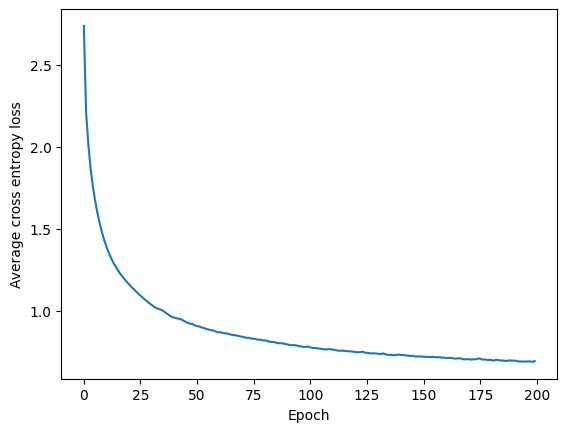

In [9]:
# Hyperparameters
num_hidden = 256 # The number of units in the gated recurrent unit network
lr = 0.001 # The learning rate
num_epochs = 200 # The number of epochs for training
num_steps = 64 # The length of the training sequences
batch_size = 32 # The number of training sequences per batch

# Model
grulm = GRULanguageModel(vocab, num_hidden=num_hidden)

# Loss and optimizer
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(grulm.parameters(), lr=lr)

# Training loop
epoch_losses = []
for epoch in range(num_epochs):
    train_iter = sequential_partitioning(indices, batch_size=batch_size, num_steps=num_steps)

    state = grulm.initial_state(batch_size) # A 1 x `batch_size` x `num_hidden` tensor filled with zeros

    losses = [] # Stores the loss for each batch

    for X, Y in train_iter:
        logits, state = grulm(X, state) # Computes the `num_steps` x `batch_size` x `len(vocab)` logits tensor for the `num_steps` x `batch_size` tensor of indices `X`, based on the current `state`

        Y_flat = Y.reshape(-1) # Flattens the `num_steps` x `batch_size` tensor of (target) indices `Y` into a vector with `num_steps` * `batch_size` elements
        logits_flat = logits.reshape(-1, logits.shape[2]) # Reshapes the `num_steps` x `batch_size` x `len(vocab)` logits tensor into a `num_steps` * `batch_size` x `len(vocab)` logits matrix

        l = loss(logits_flat, Y_flat) # Computes the loss given the logits matrix `logits_flat` and the target vector `Y_flat`

        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters
        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch

        state = state.clone().detach() # A 1 x `batch_size` x `num_hidden` tensor that carries the current state across batches

    epoch_losses.append(np.mean(losses))

    print(f'Epoch {epoch + 1}/{num_epochs}. Loss: {epoch_losses[-1]:.5f}.')

plt.plot(epoch_losses) # Plots the average loss across batches for each epoch
plt.xlabel('Epoch')
plt.ylabel('Average cross entropy loss')
plt.show()

# Text generation

* The following code generates text using the trained gated recurrent unit language model.

* You may obtain different results by running the cell multiple times (and changing the temperature)

In [47]:
grulm.generate('therefore', n_tokens=512, temperature=0.1)

'therefore what could i consider the sun had indeed allow me to expect i shall have the compassion and rain uron least and was strengte son when henry returned to the same signisity and stretched mation i am a resolution to life some of the spirits that grand upon the scene that i felt the fie the attempt and sprengul in an air of every great and feel the remainder of the same of the summits of the words in a moment from the moonstated hatred of the most distinguished discoverers he appeared to me as i believe that i'